# Sample Notebook ( Regression )

This is a sample notebook for a regression type of ML application

In [20]:
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import pandas as pd
import math

### Data Loading

In [3]:
# load and summarize the california housing dataset
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing(return_X_y=False, as_frame=True)

In [4]:
# checkout the structure and shape of the dataset
dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])

In [5]:
dataset.data.shape

(20640, 8)

### Data Inspection
Look at :
 1. Data distributions 
 2. Basic statistics
 3. Correlations between features and target

In [6]:
# inspect dataset
print('dataset instances : %d' %len(dataset.data))
print('dataset features  : %s' %len(dataset.feature_names))
print('dataset atributes : %s' %dataset.feature_names)
print('dataset feature   : %s' %dataset.target_names)

dataset instances : 20640
dataset features  : 8
dataset atributes : ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
dataset feature   : ['MedHouseVal']


In [8]:
X = dataset.data
y = dataset.target

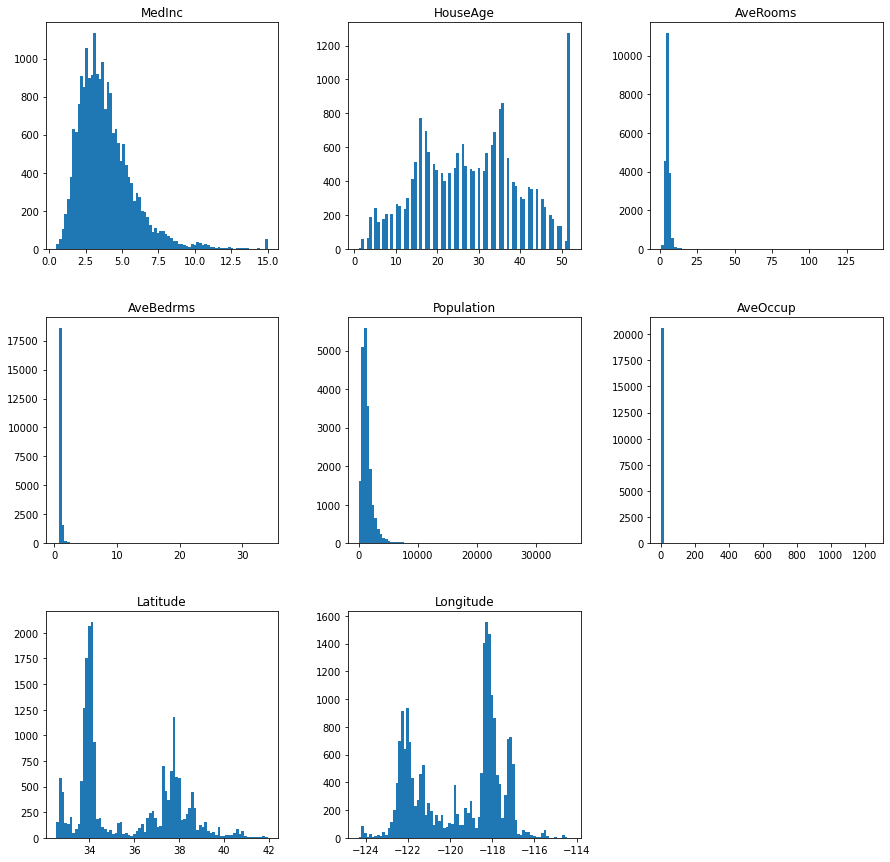

In [37]:
# Data Distributions
X.hist(bins=80, figsize=(15, 15), grid=False);

In [14]:
# Basic statistics
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


From the histograms and basic statistics we can already see here 2 important points regarding the dataset:

 1. Basic Statistics : some of the attributes contain outliers, like AveRooms and AveBedrms  
 2. Distributions : the scales of the attributes are quite different


 Conclusions:

 1. Some outliers treatment is necessary (removal of outliers for example)
 2. Some data standarization is also necessary to bring all features into an equivalent scale . This is done to avoid the variance scale from a large feature to dominate and bias the model.

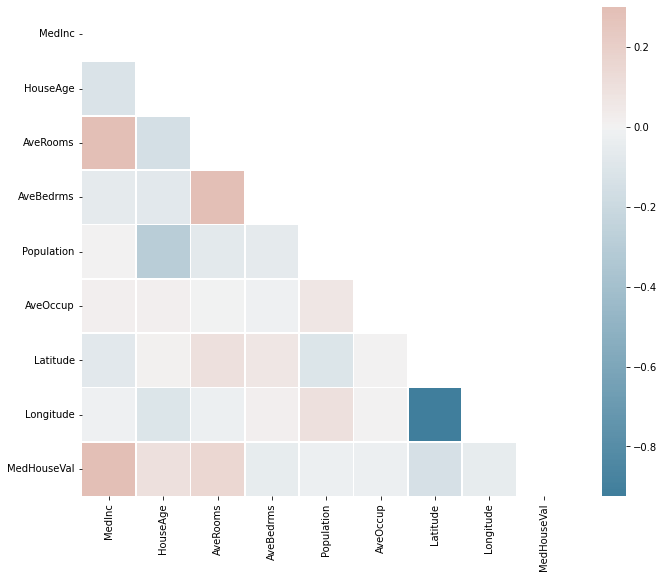

In [22]:
# Correlations between feature and target
import seaborn as sns
corr = dataset_scaled.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5);

In [46]:
# outlier detection using covariance
from sklearn.covariance import EllipticEnvelope
cov = EllipticEnvelope(random_state=0).fit(X)
# check outliers on each attribute : predict returns 1 for an inlier and -1 for an outlier
covariances=cov.predict(X)
outliers=[i for i in range(len(covariances)) if covariances[i] == -1]
print('found : %2d outliers in data' %len(outliers))

found : 2064 outliers in data


We can already see there is a stronger correlation between Average Rooms for example and Mean House Value.
We could use this in order to select stronger features for training.

### Model Training

In [56]:
# apply transformations to the attrributes and target
X_scaled = MinMaxScaler().fit_transform(X) 
y_scaled = MinMaxScaler().fit_transform(y.values.reshape(-1, 1))

In [57]:
# evaluate several regression algorithms on the dataset and create several models
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# define a dictionary with the algorithms we would like to test out on the data
# Note : model hyperparameters here are not tuned!
models = {
    'LinearRegression' : LinearRegression(),
    'ElasticNet' : ElasticNet(alpha=1.0, l1_ratio=0.5),
    'RandomForestRegressor' : RandomForestRegressor(n_estimators=10),
}

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
for name,model in models.items():
    # evaluate model
    scores = cross_val_score(model, X_scaled, y_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    # force scores to be positive
    scores = abs(scores)
    print('Model : %-24s Mean MAE: %.3f (%.3f)' % (name , scores.mean(), scores.std()))

Model : LinearRegression         Mean MAE: 0.110 (0.002)
Model : ElasticNet               Mean MAE: 0.188 (0.003)
Model : RandomForestRegressor    Mean MAE: 0.071 (0.002)


### Model Predict

In [47]:
X.iloc[0]

MedInc          8.325200
HouseAge       41.000000
AveRooms        6.984127
AveBedrms       1.023810
Population    322.000000
AveOccup        2.555556
Latitude       37.880000
Longitude    -122.230000
Name: 0, dtype: float64

In [48]:
y.iloc[0]

4.526

In [80]:
# Select the best model and make a prediction with it
selected_model='RandomForestRegressor'
model = models[selected_model]
# fit model
model.fit(X_scaled, y_scaled)
# define new data to predict the value of the house
new_housing_data = [8.32,41,6.98,1,322,2.55,37.88,-122]
scaler=MinMaxScaler().fit_transform(np.array(new_housing_data).reshape(-1,1))
# make a prediction
y_predicted = model.predict(new_housing_data_scaled.T)
y_scaler = MinMaxScaler().fit(y.values.reshape(-1,1))
# summarize prediction , inverse back the scaled prediction
print('House Predicted Value (KDollar): %.3f' %y_scaler.inverse_transform(y_predicted.reshape(-1,1)))

/Users/asierabreu/opt/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


House Predicted Value (KDollar): 4.389
